In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

## imports
# general
import os
import pathlib
import glob

# data science
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# single cell
import scanpy as sc  # main package for single cell analysis
import loompy as lp
import anndata as ad

# pyscenic
from distributed import Client, LocalCluster

from dask.diagnostics import ProgressBar
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.plotting import plot_binarization

## settings
# set paths
PATH_PROJ_DIR = pathlib.Path(".")  # project directory
PATH_DATA_DIR = pathlib.Path(PATH_PROJ_DIR) / "data"
PATH_FIG_DIR = pathlib.Path(PATH_PROJ_DIR) / "figures" / "scenic_run-and-analysis"
# create figures directory if it does not exist
PATH_FIG_DIR.mkdir(parents=True, exist_ok=True)

# export matplotlib as pdfs
plt.rcParams["pdf.fonttype"] = 42  # set font type for pdfs
plt.rcParams["ps.fonttype"] = 42  # set font type for postscript files

FIG_TYPE = "svg"
sc.settings._file_format_figs = FIG_TYPE
# set scanpy settings
sc.settings.figdir = PATH_FIG_DIR  # set figure directory
# svg format, dpi 100, transparent background
sc.settings.set_figure_params(format="FIG_TYPE", dpi=100, transparent=True, fontsize=8)
# disable grid
mpl.rcParams["axes.grid"] = False  # disable grid in plots


# set random seed for reproducibility
SEED = 82
np.random.seed(SEED)  # set random seed for numpy

# SCENIC Run

## Step 1: GRN Inference: Generation of Co-expression Adjacency Matrix

In [2]:
# fetch QCed barcodes from preprocessed data
adata_annotated = sc.read_h5ad(PATH_DATA_DIR / "processed/mdata_annotated_gex.h5ad")
# fetch raw UMI from unprocessed data
# load unprocessed data
adata = sc.read_10x_h5(PATH_DATA_DIR / "sample_feature_bc_matrix.h5")

# subset to just rna
adata, adata_annotated

/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(AnnData object with n_obs × n_vars = 6933 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 5684 × 36601
     obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'outliers_empty', 'outliers_multiplets', 'outliers_mito', 'outliers_ribo', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'celltypist_leiden_res1', 'celltypist_leiden_res1_conf', 'union_cd4_score', 'union_cd8_score', 'naive-cm-like_score', 'cd45ro+effector-memory_score', 'interferon-signaling_score', 'memory/proliferation_score', 'nk-like/cd45ra+effector-memory_score', 'exhaustion_score', 'Cell Type', 'Functional', 'Ross Cell Type'
     var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     

In [3]:
# intersect annotated and unannotated barcodes
adata = adata[adata.obs_names.isin(adata_annotated.obs_names)].copy()

# transfer annotations
adata.obs = adata_annotated.obs.loc[adata.obs_names].copy()
# transfer variables
adata.var = adata_annotated.var.copy()
# transfer uns
adata.uns = adata_annotated.uns.copy()
# transfer obsm
adata.obsm = adata_annotated.obsm.copy()

adata

AnnData object with n_obs × n_vars = 5684 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'outliers_empty', 'outliers_multiplets', 'outliers_mito', 'outliers_ribo', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'celltypist_leiden_res1', 'celltypist_leiden_res1_conf', 'union_cd4_score', 'union_cd8_score', 'naive-cm-like_score', 'cd45ro+effector-memory_score', 'interferon-signaling_score', 'memory/proliferation_score', 'nk-like/cd45ra+effector-memory_score', 'exhaustion_score', 'Cell Type', 'Functional', 'Ross Cell Type'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cell Type_colors', 'Functional_colors', 'Ross Cell Type_colors', 'celltypist_leiden_res1_colors', 

In [4]:
# require the gene to be expressed at least once; helps for computational efficiency
adata.var_names_make_unique()
# it seems genes were already filtered based on < 20k present in the dataset
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 5684 × 19500
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'outliers_empty', 'outliers_multiplets', 'outliers_mito', 'outliers_ribo', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'celltypist_leiden_res1', 'celltypist_leiden_res1_conf', 'union_cd4_score', 'union_cd8_score', 'naive-cm-like_score', 'cd45ro+effector-memory_score', 'interferon-signaling_score', 'memory/proliferation_score', 'nk-like/cd45ra+effector-memory_score', 'exhaustion_score', 'Cell Type', 'Functional', 'Ross Cell Type'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells'
    uns: 'Cell Type_colors', 'Functional_colors', 'Ross Cell Type_colors', 'celltypist_leiden_res

In [5]:
tf_names = load_tf_names(f"{PATH_DATA_DIR}/scenic/allTFs_hg38.txt")
tf_names

['ZNF354C',
 'KLF12',
 'ZNF143',
 'ZIC2',
 'ZNF274',
 'SP2',
 'ZBTB7A',
 'BCL6B',
 'ZBTB49',
 'ZIC1',
 'ZNF232',
 'ZNF282',
 'ZNF410',
 'ZSCAN16',
 'ZNF524',
 'ZNF713',
 'ZNF75A',
 'ZSCAN4',
 'ZNF200',
 'SNAI2',
 'KLF1',
 'BCL6',
 'EGR2',
 'OVOL2',
 'GFI1',
 'GFI1B',
 'KLF11',
 'WT1',
 'ZNF655',
 'FOXC1',
 'ARX',
 'VSX1',
 'CRX',
 'PBX4',
 'PHOX2B',
 'VAX2',
 'VSX2',
 'MSX2',
 'ESX1',
 'HOXD13',
 'NKX2-8',
 'VENTX',
 'HESX1',
 'PITX2',
 'PROP1',
 'ISX',
 'NKX2-5',
 'SIX6',
 'HOXC4',
 'HOXB7',
 'PAX6',
 'PAX7',
 'PAX4',
 'PAX3',
 'POU4F3',
 'POU6F2',
 'POU3F4',
 'NR1H4',
 'NR2E3',
 'POU2F1',
 'RBPJ',
 'FOXP1',
 'MAX',
 'PHF1',
 'MTF2',
 'BCL11A',
 'BCL11B',
 'FOXN2',
 'FOXR1',
 'SOX4',
 'SOHLH2',
 'ZSCAN29',
 'PLAGL2',
 'VEZF1',
 'ZBTB44',
 'CENPBD1',
 'TIGD1',
 'CXXC5',
 'FOXN3',
 'HDX',
 'DUXA',
 'MSANTD3',
 'ZZZ3',
 'LCORL',
 'NFATC4',
 'CUX2',
 'CUX1',
 'DLX3',
 'LHX9',
 'POU5F1B',
 'NFATC2',
 'ZFHX3',
 'KDM2B',
 'KMT2A',
 'DNMT1',
 'TET1',
 'DMRT3',
 'DMRT1',
 'DMRTA2',
 'DMRT2',
 

In [6]:
DATABASES_GLOB = os.path.join(
    f"{PATH_DATA_DIR}/scenic", "hg38*.genes_vs_motifs.rankings.feather"
)
db_fnames = glob.glob(DATABASES_GLOB)


def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]


dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings")]

In [ ]:
adjacencies = grnboost2(
    expression_data=adata.X,
    gene_names=list(adata.var_names.values),
    tf_names=tf_names,
    verbose=True,
    seed=SEED,
)
adjacencies

preparing dask client


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
distributed.diskutils - INFO - Found stale lock file and directory '/home/divy/projects/jones-salim_tuning/dask-worker-space/worker-9401jr74', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/divy/projects/jones-salim_tuning/dask-worker-space/worker-91jh73n_', purging
distributed.di

parsing input
creating dask graph
16 partitions
computing dask graph


distributed.worker - ERROR - Exception during execution of task infer_partial_network-44b9c40dba11419ff5dd6638f2ffcf6b.
Traceback (most recent call last):
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/distributed/worker.py", line 3646, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'str-eca13731672c65a2e1352a056ae47c2a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/distributed/worker.py", line 3528, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/distributed/worker.py", line 3650, in _prepare_args_for_execution
    data[k] = Actor(type(self.actors[k]), self.address, k, self)
Key

shutting down client and local cluster


distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33117
Traceback (most recent call last):
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/distributed/worker.py", line 3072, in gather_dep
    self.rpc, to_gather_keys, worker, who=self.address
  File "/home/divy/miniconda3/envs/scenic/lib/python3.7/site-packages/distributed/worker.py", line 4377, in get_data_from_worker
    return await retry_operation(_get_data, operation="get_data_from_worker")

In [9]:
DATABASES_GLOB = os.path.join(
    f"{PATH_DATA_DIR}/scenic", "hg38*.genes_vs_motifs.rankings.feather"
)
db_fnames = glob.glob(DATABASES_GLOB)


def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]


dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings")]

In [ ]:
## build loom object of the adata
# row attributes (transpose of adata column = genes)
row_attrs = {
    "Gene": np.array(adata.var.index),
}
# column attributes (transpose of adata rows = cell-barcodes)
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
}

loom_path = f"{PATH_DATA_DIR}/scenic/ross-salim_qced.loom"
lp.create(loom_path, adata.X.transpose(), row_attrs, col_attrs)

running this using screen -S makes most sense, takes few hours... (slurm seems to have memory overflow issues)
> !bash slurm/scripts/run_scenic_grn.sh

## Step 2

In [ ]:
adjacencies = pd.read_csv(
    f"{BASE_DATA_PATH}/scenic/CD4_seq_rna_preprocessed_regressed_named(unpaired).adj.csv",
    index_col=False,
)
adjacencies

,TF,target,importance
0,RPS4X,EEF1A1,2.319666e+02
1,RPS4X,RPS12,2.118350e+02
2,RPS4X,RPLP1,2.075676e+02
3,RPS4X,RPL10,2.011918e+02
4,RPS4X,RPS3,2.008123e+02
...,...,...,...
2081083,ACAA1,TRBV4-1,1.723927e-19
2081084,PDLIM5,TRBV28,1.692407e-19
2081085,BATF,TRBV7-9,1.573348e-19
2081086,NMI,CCL4,1.357682e-19


run via slurm:
> !bash slurm/scripts/run_scenic_ctx.sh

## Step 3: AUCell

run via slurm:
> !sbatch slurm/scripts/run_scenic_ctx.sh

In [ ]:
# remove any prior adata obj
if "adata" in globals():
    del adata

# generate path to data
data_path_prefix = f"{BASE_DATA_PATH}/processed"
data_name = f"CD4_seq_rna_preprocessed_regressed_named(unpaired)_cd4cd8only"
data_path = f"{data_path_prefix}/{data_name}.h5ad"

# load adata
print(f"Loading in {data_path}")
adata = sc.read_h5ad(data_path)
adata

Loading in /projects/epigenomics3/epigenomics3_results/users/draval/projects/jones-stankiewicz_i4sp/data/processed/CD4_seq_rna_preprocessed_regressed_named(unpaired)_cd4cd8only.h5ad


AnnData object with n_obs × n_vars = 1753 × 16947
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'rna_leiden', 'celltype', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'rna_leiden_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
## read aucell loom into anndata
# collect SCENIC AUCell output
lf = lp.connect(
    f"{BASE_DATA_PATH}/scenic/CD4_seq_rna_preprocessed_regressed_named(unpaired)_cd4cd8only-scenic.aucell.loom",
    mode="r+",
    validate=False,
)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

## convert to anndata and transfer observations
adata_auc = ad.AnnData(auc_mtx)
adata_auc.obs = adata.obs
adata_auc.obsm["X_rna_pca"] = adata.obsm["X_pca"]
adata_auc.obsm["X_rna_umap"] = adata.obsm["X_umap"]
adata_auc

AnnData object with n_obs × n_vars = 1753 × 226
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'rna_leiden', 'celltype', 'S_score', 'G2M_score', 'phase'
    obsm: 'X_rna_pca', 'X_rna_umap'

In [ ]:
# produce a binarized version of aucell_mtx
adata_auc.layers["binary"], adata_auc.var["auc_thresholds"] = binarize(
    auc_mtx=auc_mtx, seed=82, num_workers=20
)
adata_auc

AnnData object with n_obs × n_vars = 1753 × 226
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'rna_leiden', 'celltype', 'S_score', 'G2M_score', 'phase'
    var: 'auc_thresholds'
    obsm: 'X_rna_pca', 'X_rna_umap'
    layers: 'binary'

In [ ]:
adata_auc.write(
    f"{BASE_DATA_PATH}/scenic/CD4_seq_rna_preprocessed_regressed_named(unpaired)_cd4cd8only-complete.h5ad"
)

# Analysis

In [ ]:
## load scenic data
adata_auc = sc.read_h5ad(
    f"{BASE_DATA_PATH}/scenic/CD4_seq_rna_preprocessed_regressed_named(unpaired)_cd4cd8only-complete.h5ad"
)
adata_auc_bin = adata_auc.copy()
adata_auc_bin.X = adata_auc.layers["binary"]

## set paths
new_mod = "scenic-analysis"
fig_save_loc = sc.settings.figdir = f"{BASE_FIG_PATH}/{new_mod}"
pathlib.Path(fig_save_loc).mkdir(parents=True, exist_ok=True)

adata_auc

AnnData object with n_obs × n_vars = 1753 × 226
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'rna_leiden', 'celltype', 'S_score', 'G2M_score', 'phase'
    var: 'auc_thresholds'
    obsm: 'X_rna_pca', 'X_rna_umap'
    layers: 'binary'

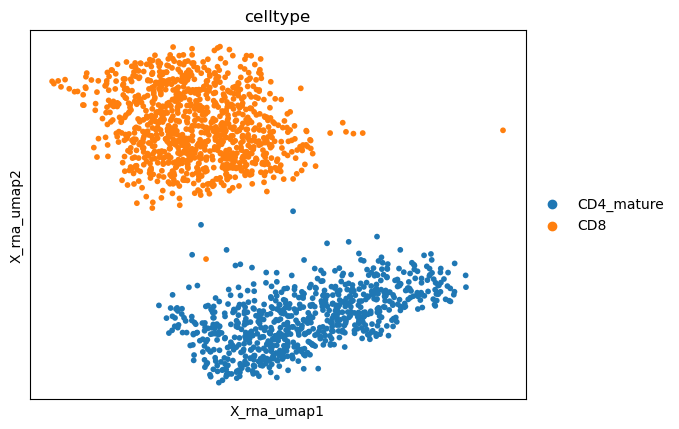

In [3]:
sc.pl.embedding(adata_auc, "X_rna_umap", color=["celltype"])

In [ ]:
sc.pl.clustermap(adata_auc, cmap="Greys", obs_keys="celltype")
sc.pl.clustermap(adata_auc, cmap="Greys", obs_keys="rna_leiden")

In [ ]:
sc.pl.clustermap(adata_auc_bin, cmap="Greys", obs_keys="celltype")
sc.pl.clustermap(adata_auc_bin, cmap="Greys", obs_keys="rna_leiden")

In [ ]:
sc.pp.pca(adata_auc, n_comps=50, mask_var=None, svd_solver="arpack")
sc.pp.neighbors(
    adata_auc,
    n_pcs=50,
    use_rep="X_pca",
    n_neighbors=20,
    metric="euclidean",
)
sc.tl.umap(adata_auc, min_dist=1)

sc.pp.pca(adata_auc_bin, n_comps=50, mask_var=None, svd_solver="arpack")
sc.pp.neighbors(
    adata_auc_bin,
    n_pcs=50,
    use_rep="X_pca",
    n_neighbors=20,
    metric="correlation",
)
sc.tl.umap(adata_auc_bin, min_dist=1)

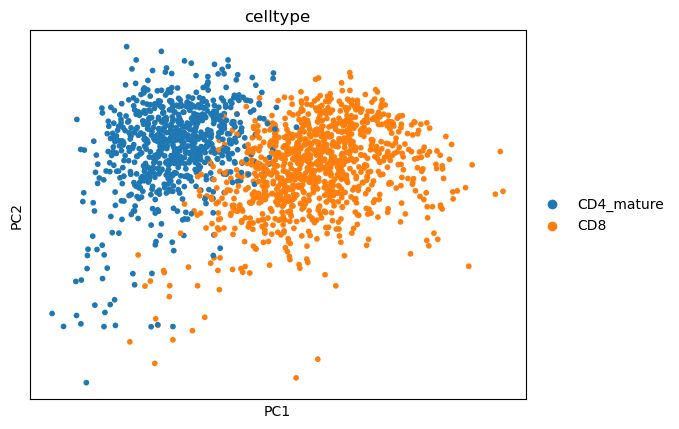

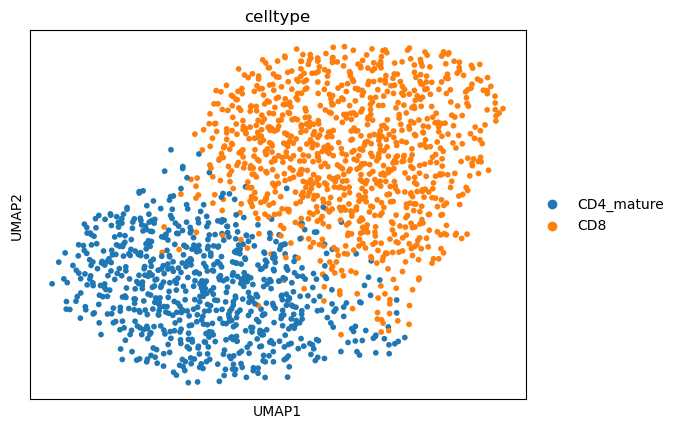

In [5]:
sc.pl.pca(adata_auc, color=["celltype"], wspace=0.3)
sc.pl.umap(adata_auc, color=["celltype"], wspace=0.3)

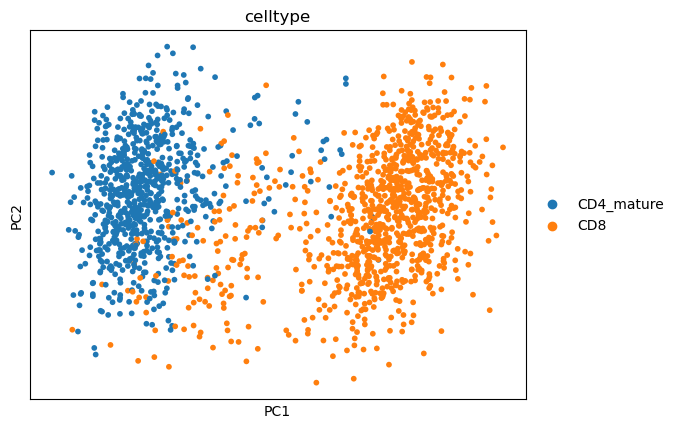

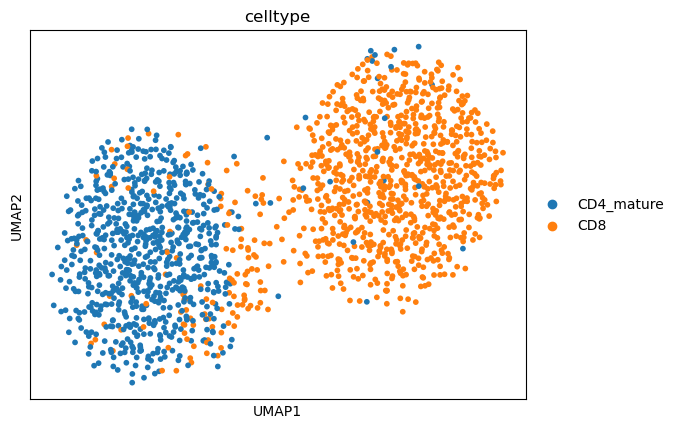

In [6]:
sc.pl.pca(adata_auc_bin, color=["celltype"], wspace=0.3)
sc.pl.umap(adata_auc_bin, color=["celltype"], wspace=0.3)

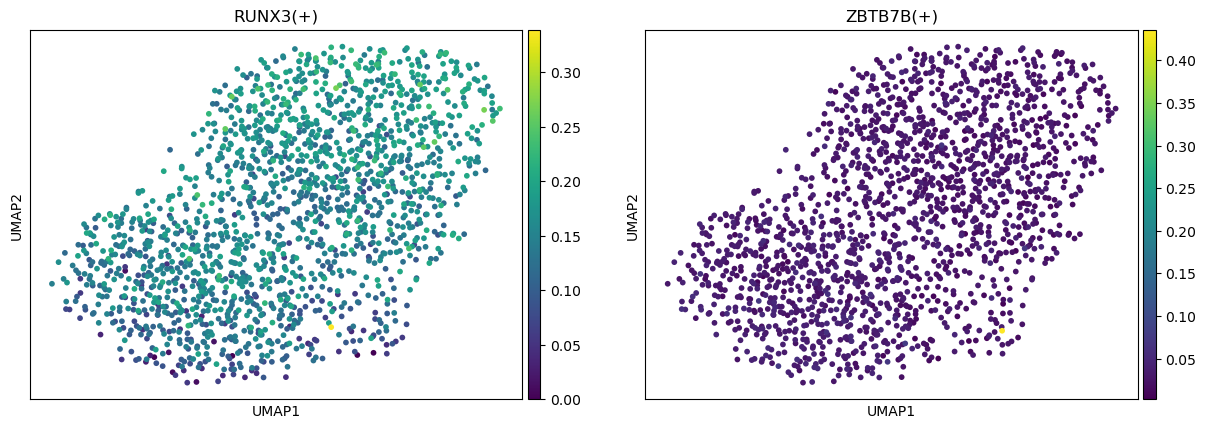

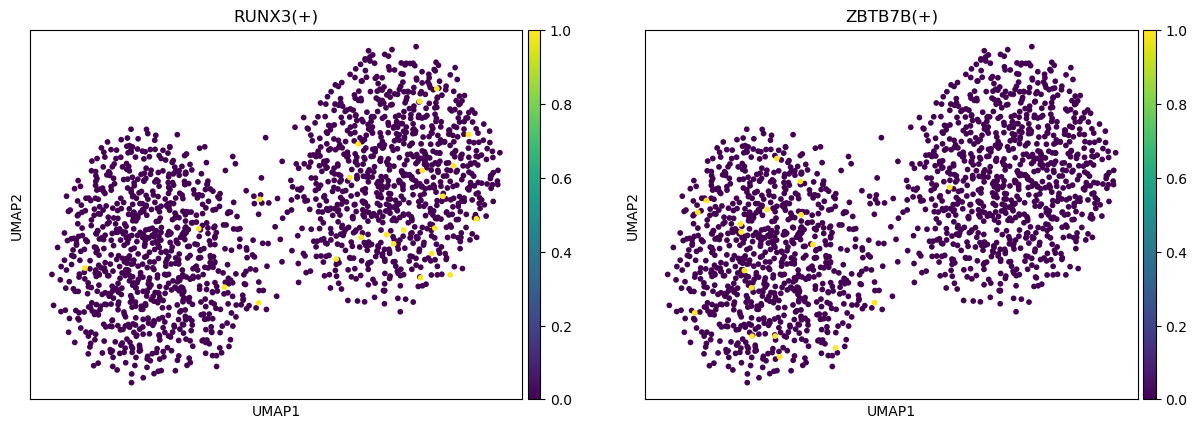

In [ ]:
genes_list = np.array(["RUNX3", "ZBTB7B"])


def is_scenic_tf(adata, symbols: list):
    # tfs = np.loadtxt(f"{BASE_DATA_PATH}/scenic/allTFs_hg38.txt", dtype=str)
    tfs = adata.var_names
    symbols = [e + "(+)" for e in symbols]
    symbols = np.array(symbols)

    return symbols[list(map(lambda x: x in tfs, symbols))]


sc.pl.umap(adata_auc, color=is_scenic_tf(adata_auc, genes_list))
sc.pl.umap(adata_auc_bin, color=is_scenic_tf(adata_auc, genes_list))

In [12]:
group = "celltype"
key = f"dge_{group}"
sc.tl.rank_genes_groups(adata_auc, groupby=group, method="wilcoxon", key_added=key)
adata_auc

AnnData object with n_obs × n_vars = 1753 × 226
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'rna_leiden', 'celltype', 'S_score', 'G2M_score', 'phase'
    var: 'auc_thresholds'
    uns: 'celltype_colors', 'pca', 'neighbors', 'umap', 'dge_celltype'
    obsm: 'X_rna_pca', 'X_rna_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'binary'
    obsp: 'distances', 'connectivities'

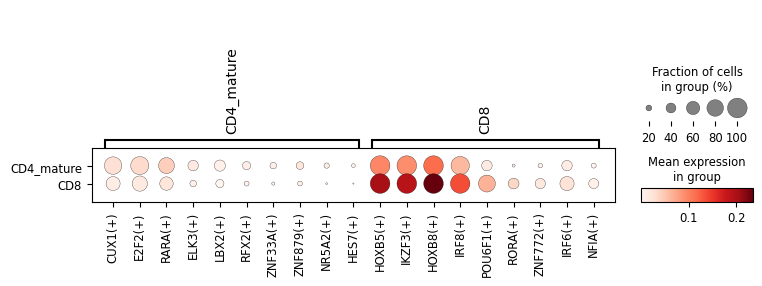

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata_auc, key=key, min_logfoldchange=1, n_genes=10, cmap="Reds"
)

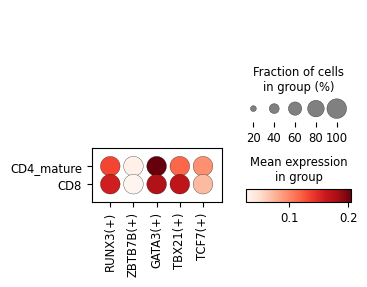

In [25]:
genes_list = ["RUNX3", "ZBTB7B", "GATA3", "TBX21", "TCF7"]
sc.pl.dotplot(adata_auc, groupby=group, var_names=is_scenic_tf(adata_auc, genes_list))